# Locating startups and shutdowns
In the initial exploration, we used a quick-and-dirty method of removing cold starts by filtering out 1) load near zero and 2) the bottom X percent of load. That was good enough for a proof of concept, but unsuitable for plants with low capacity factors or wide operational power bands.

In this notebook I explore different methods of identifying cold starts that leverage the time series aspect of the data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data.load_dataset import load_epacems
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
idx = pd.IndexSlice

In [4]:
# all states, 1 year, all columns
cems = load_epacems(states=None, years=[2019], columns=None, engine='pandas')

In [5]:
cems.loc[:, 'unitid'] = cems.loc[:, 'unitid'].astype('category', copy=False) # save memory

In [6]:
cems.sample(3)

,plant_id_eia,unitid,operating_datetime_utc,operating_time_hours,gross_load_mw,steam_load_1000_lbs,so2_mass_lbs,so2_mass_measurement_code,nox_rate_lbs_mmbtu,nox_rate_measurement_code,nox_mass_lbs,nox_mass_measurement_code,co2_mass_tons,co2_mass_measurement_code,heat_content_mmbtu,facility_id,unit_id_epa,year,state
11029165,55236,CT1,2019-12-25 19:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1362,4266,2019,IL
11011815,55201,GCTG1,2019-12-15 21:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1334,4126,2019,IL
27051562,55298,1A,2019-03-14 15:00:00+00:00,1.0,287.0,NaN,1.114,Measured,0.007,Measured,13.0,Measured,110.300003,Measured,1855.900024,1410,4475,2019,PA


## First, what is a good primary key for this dataset?
* not null
* unique

In [7]:
cems.isna().any()

plant_id_eia                 False
unitid                       False
operating_datetime_utc       False
operating_time_hours          True
gross_load_mw                False
steam_load_1000_lbs           True
so2_mass_lbs                  True
so2_mass_measurement_code     True
nox_rate_lbs_mmbtu            True
nox_rate_measurement_code     True
nox_mass_lbs                  True
nox_mass_measurement_code     True
co2_mass_tons                 True
co2_mass_measurement_code     True
heat_content_mmbtu           False
facility_id                  False
unit_id_epa                  False
year                         False
state                        False
dtype: bool

In [8]:
n_uniques = cems.groupby('operating_datetime_utc').nunique()

In [9]:
counts = cems.groupby('operating_datetime_utc').count()

In [10]:
# check they are equal over all time
n_uniques.eq(counts.max(axis=1), axis=0).all()

plant_id_eia                 False
unitid                       False
operating_time_hours         False
gross_load_mw                False
steam_load_1000_lbs          False
so2_mass_lbs                 False
so2_mass_measurement_code    False
nox_rate_lbs_mmbtu           False
nox_rate_measurement_code    False
nox_mass_lbs                 False
nox_mass_measurement_code    False
co2_mass_tons                False
co2_mass_measurement_code    False
heat_content_mmbtu           False
facility_id                  False
unit_id_epa                   True
year                         False
state                        False
dtype: bool

In [36]:
mapping = cems[['plant_id_eia', 'unitid', 'unit_id_epa']].reset_index(drop=True).drop_duplicates()

In [39]:
mapping.duplicated(subset=['plant_id_eia', 'unitid']).any()

False

In [40]:
mapping.duplicated('unit_id_epa').any()

False

`unit_id_epa` looks like a surrogate key for combinations of `plant_id_eia` and `unitid`. I'll use that then.

In [11]:
cems.set_index(['unit_id_epa', 'operating_datetime_utc'], drop=True, inplace=True, verify_integrity=True)

In [12]:
cems.sort_values(by=['unit_id_epa', 'operating_datetime_utc'], inplace=True)

## Viz a few plant months

In [13]:
units = cems.groupby(level=['unit_id_epa'])

In [14]:
rng = np.random.default_rng(seed=2)

In [15]:
UNIT = rng.choice(cems.index.levels[0])
# unit_id_epa = 90186 for small <10 MW peaker
# unit_id_epa = 2981 for large 100 MW peaker
# UNIT = 90186
UNIT

90035

In [16]:
unit = cems.loc[idx[UNIT,:], ['gross_load_mw']]
unit.index = unit.index.droplevel('unit_id_epa') # simplify index

<AxesSubplot:title={'center':'unit_id_epa: 90035'}, xlabel='operating_datetime_utc', ylabel='gross_load_mw'>

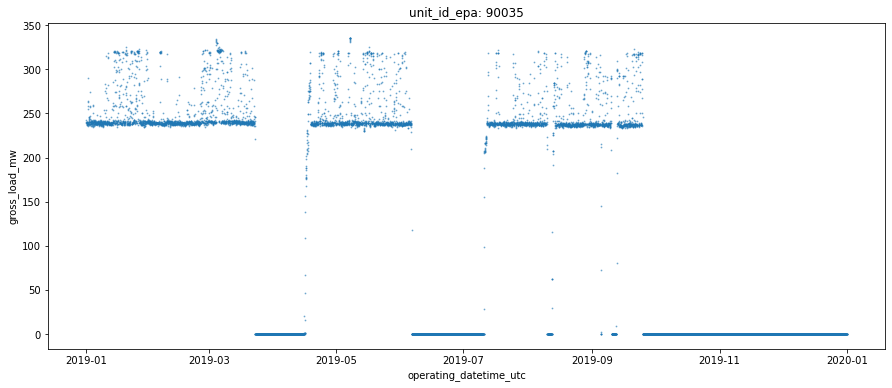

In [17]:
unit.reset_index().plot.scatter(x='operating_datetime_utc', y='gross_load_mw', figsize=(15,6), marker='.', alpha=0.5, s=3, title=f'unit_id_epa: {UNIT}')

An aside: UNIT=90667 shows a curved max capacity - thermally limited in the summer. Also, the two biggest outages are in the spring/fall 'shoulders' when demand is lowest. A good plant for demonstrating these phenomena.

In [18]:
MONTH = rng.choice(range(1,13))
MONTH

4

In [19]:
START = f'2019-{MONTH}-01'
END = f'2019-{MONTH + 1}-01' if MONTH < 12 else '2019-12-31'
print(START, END)

2019-4-01 2019-5-01


In [20]:
row_slice = idx[UNIT, START:END]

<AxesSubplot:xlabel='operating_datetime_utc'>

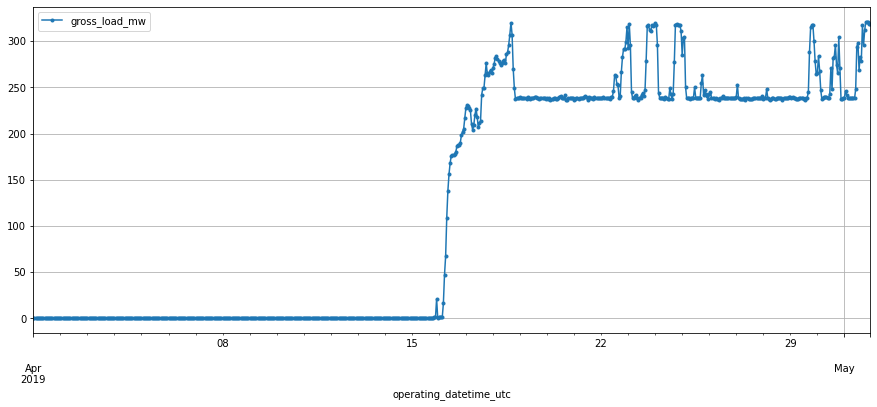

In [21]:
unit[START:END].plot(marker='.', figsize=(15,6), grid=True)

## Check distribution of near-zero values - can I use equality to zero or is there noise?

<AxesSubplot:>

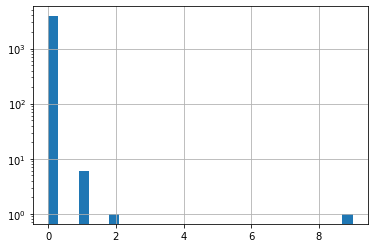

In [22]:
# one plant
unit.loc[unit['gross_load_mw'] < 15, 'gross_load_mw'].hist(bins=30, log=True)

<AxesSubplot:>

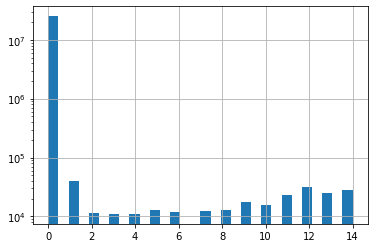

In [23]:
# all plants
cems.loc[cems['gross_load_mw'] < 15, 'gross_load_mw'].hist(bins=30, log=True)

There are a suspiciously high number of 1 values in the full dataset, which suggests some noise distribution spilling out from the zero values.

But this might be an artifact of different plant sizes (many small plants). Does it persist if I normalize by plant capacity?
### Normalize by plant capacity

<AxesSubplot:>

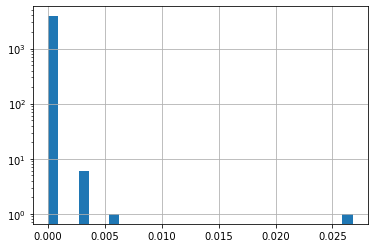

In [24]:
# one plant
unit.loc[unit['gross_load_mw'] < 15, 'gross_load_mw'].div(unit['gross_load_mw'].max()).hist(bins=30, log=True)

In [25]:
load_factor = units['gross_load_mw'].transform(lambda x: x.div(x.max()))

<AxesSubplot:>

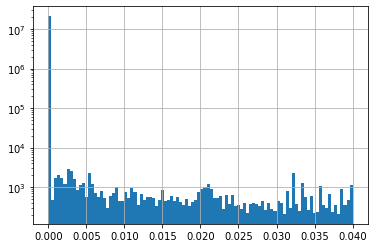

In [26]:
# all plants, load factor less than 4 percent, log y axis
load_factor[load_factor < 0.04].hist(bins=100, log=True)

Yes, there is still a noticable bump of load factors near zero.


### Conclusion: the noise doesn't matter for this purpose
On second thought, near-zero noise doesn't impact startup/shutdown finding or ramp rate filtering.

Spurious non-zero values create spurious edges in the middle of a block of zeros. But these spurious edges won't effect max ramp rates nor will they effect the distance metric used to filter out starts/stops (proximity to edges). A real non-zero value will always be closer to a real edge than to a spurious one in the middle of a block.

If the noise is on the edge of a block of zeros, it is indistinguishable from real ramping. That is a resolution limitation of the data.

**I'll filter on zero**

## Use a digital edge finder to extract start/stops

In [27]:
diff = unit.gt(0).astype(np.int8).diff().squeeze()

<AxesSubplot:xlabel='operating_datetime_utc'>

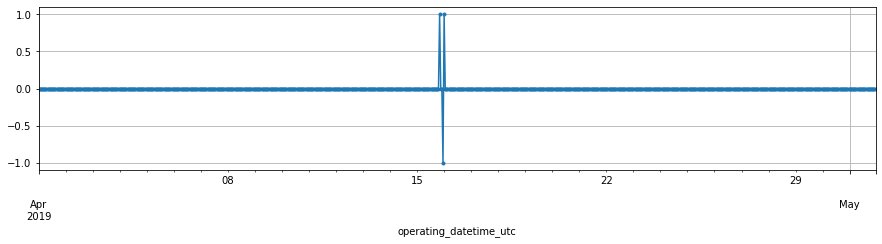

In [28]:
diff[START:END].plot(marker='.', figsize=(15,3), grid=True)

In [29]:
starts = unit[diff.shift(-1) == 1] # shift(-1) to select last zero instead of first non-zero
stops = unit[diff == -1] # no shift needed for this side - selects first zero value

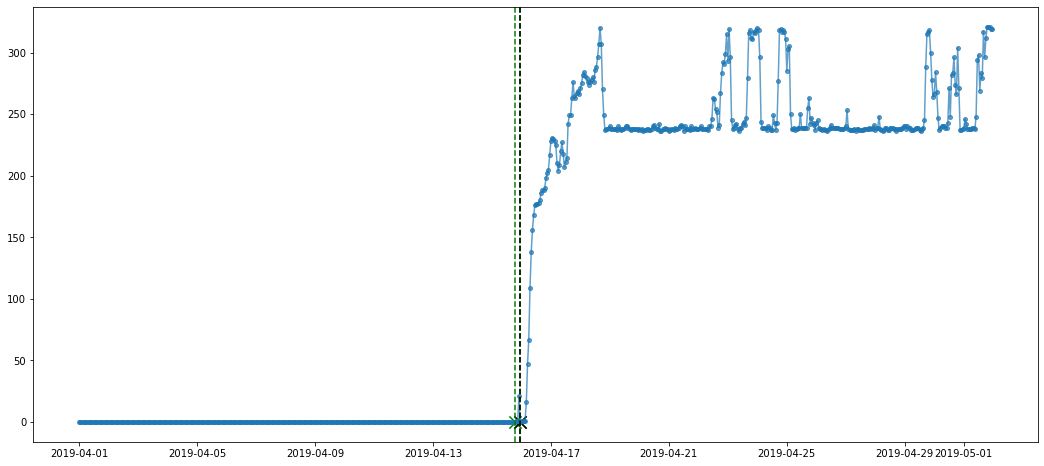

In [30]:
fig, ax = plt.subplots(figsize=(18,8))
ax.scatter(starts[START:END].index, starts[START:END], c="g", s=150, marker='x')
ax.scatter(stops[START:END].index, stops[START:END], c="k", s=150, marker='x')
ax.plot(unit[START:END].index, unit[START:END].values, marker='.', markersize=8, alpha=0.7)
for start in starts[START:END].index:
    ax.axvline(start, c='g', ls='--')
for stop in stops[START:END].index:
    ax.axvline(stop, c='k', ls='--')

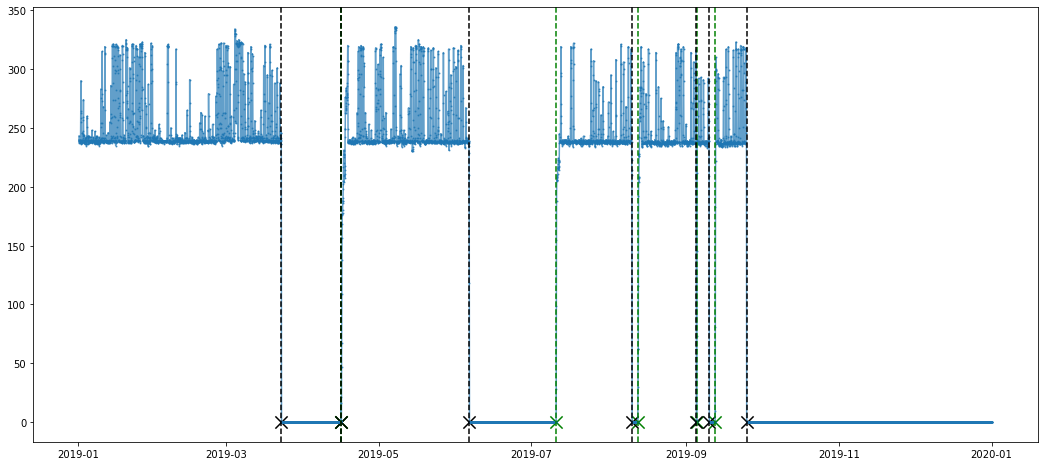

In [31]:
fig, ax = plt.subplots(figsize=(18,8))
ax.scatter(starts.index, starts, c="g", s=150, marker='x')
ax.scatter(stops.index, stops, c="k", s=150, marker='x')
ax.plot(unit.index, unit.values, marker='.', markersize=2, alpha=0.7)
for start in starts.index:
    ax.axvline(start, c='g', ls='--')
for stop in stops.index:
    ax.axvline(stop, c='k', ls='--')

## Combine start/stop indices into events

In [32]:
starts

,gross_load_mw
operating_datetime_utc,
2019-04-15 19:00:00+00:00,0.0
2019-04-15 23:00:00+00:00,0.0
2019-07-10 23:00:00+00:00,0.0
2019-08-12 15:00:00+00:00,0.0
2019-09-05 03:00:00+00:00,0.0
2019-09-12 12:00:00+00:00,0.0


In [33]:
generator_starts_at_zero = unit.iat[0,0] == 0
generator_ends_at_zero = unit.iat[-1,0] == 0
# in general, need to check for nan here
generator_starts_at_zero, generator_ends_at_zero

(False, True)

In [34]:
events = {}
nan = pd.Series([pd.NaT]).dt.tz_localize('UTC')
# confusingly, 'startup' is the end of block of zeros and 'shutdown' is the start of one
if generator_starts_at_zero: # first zero block has unknown shutdown time, known startup
    events['shutdown'] = nan.append(pd.Series(stops.index), ignore_index=True)
else: # first zero block is fully defined
    events['shutdown'] = stops.index
    
if generator_ends_at_zero: # last zero block has known shutdown but unknown startup 
    events['startup'] = pd.Series(starts.index).append(nan, ignore_index=True)
else: # last zero block is fully defined
    events['startup'] = starts.index

In [35]:
events['startup']

0   2019-04-15 19:00:00+00:00
1   2019-04-15 23:00:00+00:00
2   2019-07-10 23:00:00+00:00
3   2019-08-12 15:00:00+00:00
4   2019-09-05 03:00:00+00:00
5   2019-09-12 12:00:00+00:00
6                         NaT
dtype: datetime64[ns, UTC]

In [36]:
events = pd.DataFrame(events)
events

,shutdown,startup
0,2019-03-23 04:00:00+00:00,2019-04-15 19:00:00+00:00
1,2019-04-15 23:00:00+00:00,2019-04-15 23:00:00+00:00
2,2019-06-06 07:00:00+00:00,2019-07-10 23:00:00+00:00
3,2019-08-10 07:00:00+00:00,2019-08-12 15:00:00+00:00
4,2019-09-05 00:00:00+00:00,2019-09-05 03:00:00+00:00
5,2019-09-10 04:00:00+00:00,2019-09-12 12:00:00+00:00
6,2019-09-25 02:00:00+00:00,NaT


In [37]:
# make function - I also decided to switch the focus from downtime (blocks of zeros) to uptime (non zeros)
from src.features.build_features import _find_uptime

In [38]:
# use downtime=True to match the manual table above, which finds downtime events
_find_uptime(unit.squeeze(), downtime=True)

,shutdown,startup
0,2019-03-23 04:00:00+00:00,2019-04-15 19:00:00+00:00
1,2019-04-15 23:00:00+00:00,2019-04-15 23:00:00+00:00
2,2019-06-06 07:00:00+00:00,2019-07-10 23:00:00+00:00
3,2019-08-10 07:00:00+00:00,2019-08-12 15:00:00+00:00
4,2019-09-05 00:00:00+00:00,2019-09-05 03:00:00+00:00
5,2019-09-10 04:00:00+00:00,2019-09-12 12:00:00+00:00
6,2019-09-25 02:00:00+00:00,NaT
